In [1]:
import torch
import torch.nn.functional as F

def conv_bitwise_counts(
    x_pt: torch.Tensor,
    weights: torch.Tensor,
    input_bits: int = 8,
    weight_bits: int = 5,
    stride: int = 1,
    padding: int = 0,
):
    """
    Count bitwise (1,1),(1,0),(0,1),(0,0) multiplications
    for each input bit position during convolution.
    """

    B, C_in, H, W = x_pt.shape
    C_out, C_in_w, KH, KW = weights.shape
    assert C_in == C_in_w, "Input and weight channel dimensions must match"

    # Output spatial dimensions
    H_out = (H + 2 * padding - KH) // stride + 1
    W_out = (W + 2 * padding - KW) // stride + 1

    # Initialize per-bit counters
    bit_counts = {
        i: {"(1,1)": 0, "(1,0)": 0, "(0,1)": 0, "(0,0)": 0} for i in range(input_bits)
    }

    # Apply padding if needed
    if padding > 0:
        x_pt = F.pad(x_pt, (padding, padding, padding, padding), mode="constant", value=0)

    # Main convolution loop
    for b in range(B):
        for oc in range(C_out):
            for oy in range(H_out):
                for ox in range(W_out):
                    y0 = oy * stride
                    x0 = ox * stride
                    for ic in range(C_in):
                        for ky in range(KH):
                            for kx in range(KW):
                                x_val = int(x_pt[b, ic, y0 + ky, x0 + kx].item())
                                w_val = int(weights[oc, ic, ky, kx].item())

                                for ib in range(input_bits):
                                    xi = (x_val >> ib) & 1
                                    for wb in range(weight_bits):
                                        wi = (w_val >> wb) & 1
                                        if xi == 1 and wi == 1:
                                            bit_counts[ib]["(1,1)"] += 1
                                        elif xi == 1 and wi == 0:
                                            bit_counts[ib]["(1,0)"] += 1
                                        elif xi == 0 and wi == 1:
                                            bit_counts[ib]["(0,1)"] += 1
                                        else:
                                            bit_counts[ib]["(0,0)"] += 1

    # Print detailed results
    print("\nBitwise pair counts per input bit (LSB = bit 0):")
    for ib in range(input_bits):
        c = bit_counts[ib]
        print(f"Bit {ib}: (1,1)={c['(1,1)']}, (1,0)={c['(1,0)']}, (0,1)={c['(0,1)']}, (0,0)={c['(0,0)']}")

    return bit_counts

ip = torch.tensor([[[[1 ,0,0],
                     [0 ,0,0],
                     [0 ,0,0]]]], dtype=torch.uint8)

w1 = torch.tensor([[[[1,0,0],
                     [0,0,0],
                     [0,0,0]]]], dtype=torch.uint8)


bit_counts = conv_bitwise_counts(ip, w1, input_bits=8, weight_bits=5, stride=1, padding=0)



Bitwise pair counts per input bit (LSB = bit 0):
Bit 0: (1,1)=1, (1,0)=4, (0,1)=0, (0,0)=40
Bit 1: (1,1)=0, (1,0)=0, (0,1)=1, (0,0)=44
Bit 2: (1,1)=0, (1,0)=0, (0,1)=1, (0,0)=44
Bit 3: (1,1)=0, (1,0)=0, (0,1)=1, (0,0)=44
Bit 4: (1,1)=0, (1,0)=0, (0,1)=1, (0,0)=44
Bit 5: (1,1)=0, (1,0)=0, (0,1)=1, (0,0)=44
Bit 6: (1,1)=0, (1,0)=0, (0,1)=1, (0,0)=44
Bit 7: (1,1)=0, (1,0)=0, (0,1)=1, (0,0)=44


In [2]:
import torch
from collections import defaultdict

def conv_bitpair_position_counts(ip, w, input_bits=8, weight_bits=8):
    """
    Count bitwise pairs (1,1), (1,0), (0,1), (0,0) per bit, per output position.
    Works for any convolution kernel with stride=1, padding=0.
    """

    _, _, H, W = ip.shape
    _, _, KH, KW = w.shape
    OH, OW = H - KH + 1, W - KW + 1

    bit_summary = defaultdict(lambda: defaultdict(int))
    position_summary = {}
    position_bit_summary = {}

    for oy in range(OH):
        for ox in range(OW):
            # Extract receptive field
            region = ip[0, 0, oy:oy+KH, ox:ox+KW]
            pos_bit_counts = {}

            for bit in range(input_bits):
                c = defaultdict(int)
                ip_bit = ((region >> bit) & 1).to(torch.uint8)

                for i in range(KH):
                    for j in range(KW):
                        ip_val = ip_bit[i, j].item()
                        w_val = w[0, 0, i, j].item()

                        for wb in range(weight_bits):
                            w_bit = (w_val >> wb) & 1
                            pair = (ip_val, w_bit)
                            if pair == (1, 1):
                                c["(1,1)"] += 1
                                bit_summary[bit]["(1,1)"] += 1
                            elif pair == (1, 0):
                                c["(1,0)"] += 1
                                bit_summary[bit]["(1,0)"] += 1
                            elif pair == (0, 1):
                                c["(0,1)"] += 1
                                bit_summary[bit]["(0,1)"] += 1
                            else:
                                c["(0,0)"] += 1
                                bit_summary[bit]["(0,0)"] += 1

                pos_bit_counts[bit] = dict(c)

            position_bit_summary[(oy, ox)] = pos_bit_counts
            position_summary[(oy, ox)] = sum(sum(v.values()) for v in pos_bit_counts.values())

    bit_summary = {b: dict(v) for b, v in bit_summary.items()}
    return bit_summary, position_summary, position_bit_summary


# Example usage
ip = torch.tensor([[[[
    1, 0, 0, 0, 0, 0, 0,
    3, 0, 0, 0, 0, 0, 0,
    7, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0
]]]], dtype=torch.uint8).reshape(1, 1, 7, 7)

w1 = torch.tensor([[[[0,0,0],
                    [0,0,0],
                    [0,0,0]]]], dtype=torch.uint8)

w2 = torch.tensor([[[[4,0,0],
                    [0,13,0],
                    [0,0,31]]]], dtype=torch.uint8)

w3 = torch.tensor([[[[4,13,31],
                    [0,0,0],
                    [0,0,0]]]], dtype=torch.uint8)

bit_summary1, position_summary1, position_bit_summary1 = conv_bitpair_position_counts(
    ip, w1, input_bits=8, weight_bits=5
)

bit_summary2, position_summary2, position_bit_summary2 = conv_bitpair_position_counts(
    ip, w2, input_bits=8, weight_bits=5
)

bit_summary3, position_summary3, position_bit_summary3 = conv_bitpair_position_counts(
    ip, w3, input_bits=8, weight_bits=5
)

print("Global bitwise summary:\n", bit_summary1)
print("\nPosition total sum (5x5 output expected):\n", position_summary1)
print("\nPosition-bit breakdown for first few positions:\n", {k: position_bit_summary1[k] for k in list(position_bit_summary1)[:1]})


Global bitwise summary:
 {0: {'(1,0)': 30, '(0,0)': 1095}, 1: {'(0,0)': 1100, '(1,0)': 25}, 2: {'(0,0)': 1110, '(1,0)': 15}, 3: {'(0,0)': 1125}, 4: {'(0,0)': 1125}, 5: {'(0,0)': 1125}, 6: {'(0,0)': 1125}, 7: {'(0,0)': 1125}}

Position total sum (5x5 output expected):
 {(0, 0): 360, (0, 1): 360, (0, 2): 360, (0, 3): 360, (0, 4): 360, (1, 0): 360, (1, 1): 360, (1, 2): 360, (1, 3): 360, (1, 4): 360, (2, 0): 360, (2, 1): 360, (2, 2): 360, (2, 3): 360, (2, 4): 360, (3, 0): 360, (3, 1): 360, (3, 2): 360, (3, 3): 360, (3, 4): 360, (4, 0): 360, (4, 1): 360, (4, 2): 360, (4, 3): 360, (4, 4): 360}

Position-bit breakdown for first few positions:
 {(0, 0): {0: {'(1,0)': 15, '(0,0)': 30}, 1: {'(0,0)': 35, '(1,0)': 10}, 2: {'(0,0)': 40, '(1,0)': 5}, 3: {'(0,0)': 45}, 4: {'(0,0)': 45}, 5: {'(0,0)': 45}, 6: {'(0,0)': 45}, 7: {'(0,0)': 45}}}


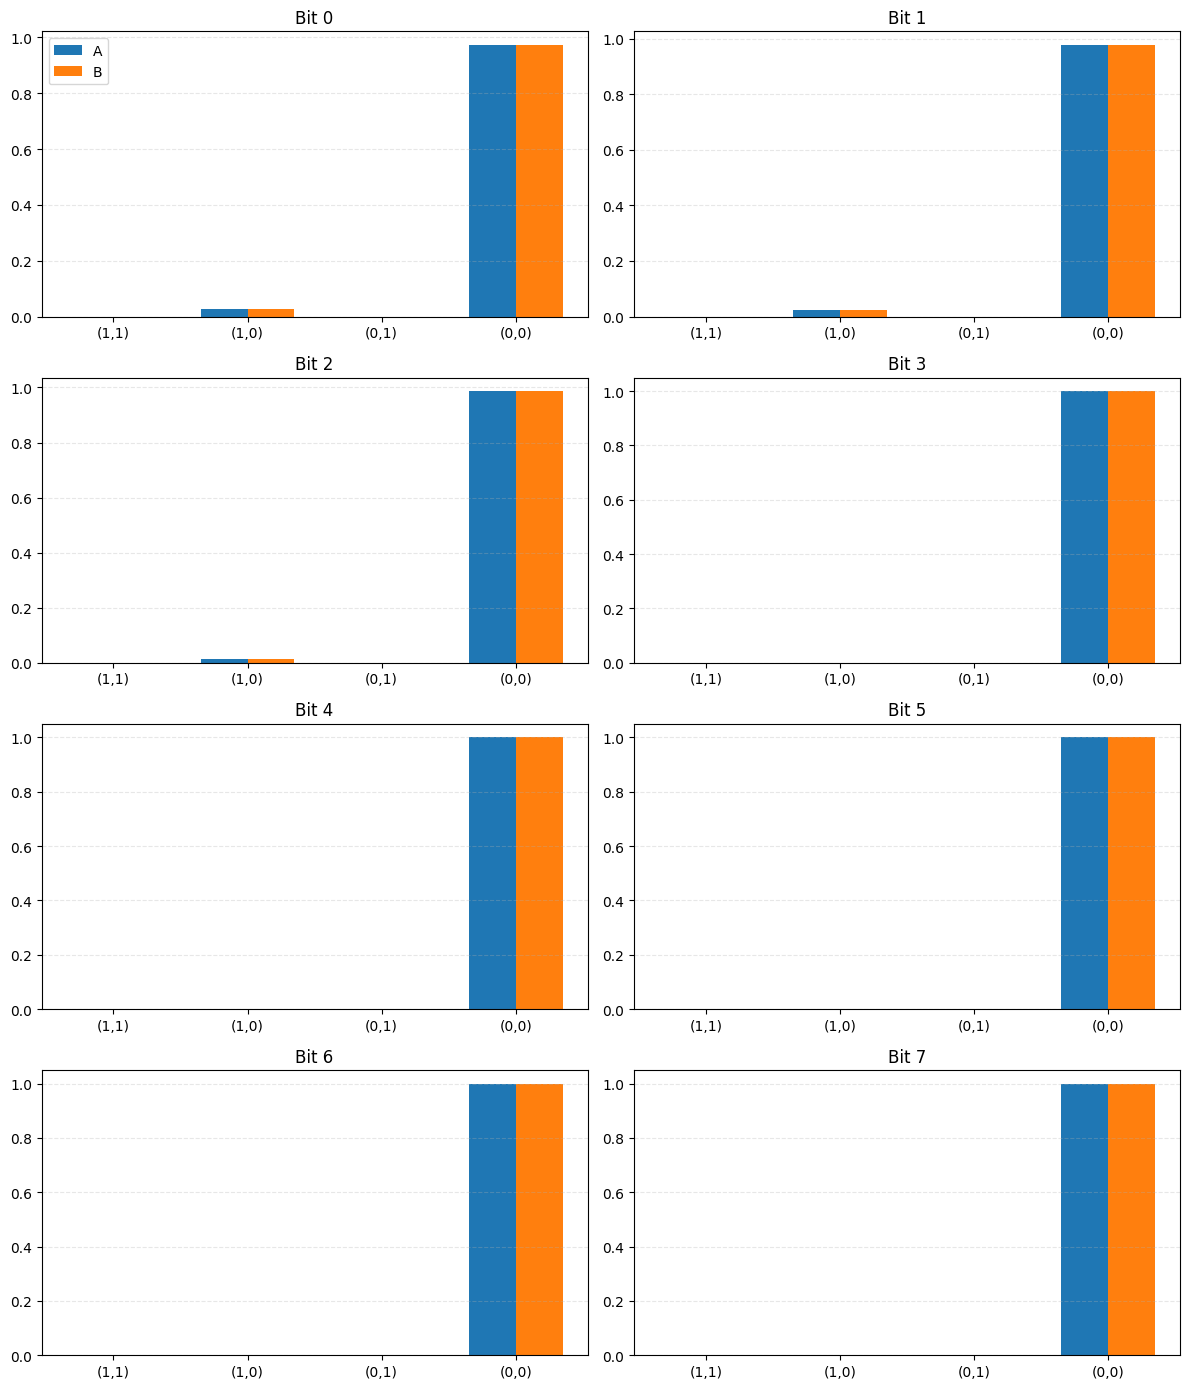

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def compare_bit_summaries(bit_summary_A, bit_summary_B, title_A="A", title_B="B"):
    """
    Compare two bit_summary dicts in a 4x2 subplot layout.
    Each subplot shows the 4 pair types, comparing counts from both summaries.
    """

    pair_types = ["(1,1)", "(1,0)", "(0,1)", "(0,0)"]
    bits = sorted(set(bit_summary_A.keys()) | set(bit_summary_B.keys()))

    fig, axes = plt.subplots(4, 2, figsize=(12, 14))
    axes = axes.flatten()

    for idx, bit in enumerate(bits):
        ax = axes[idx]
        A_counts = np.array([bit_summary_A.get(bit, {}).get(p, 0) for p in pair_types])
        B_counts = np.array([bit_summary_B.get(bit, {}).get(p, 0) for p in pair_types])

        x = np.arange(len(pair_types))
        width = 0.35

        ax.bar(x - width/2, A_counts/1125, width, label=title_A)
        ax.bar(x + width/2, B_counts/1125, width, label=title_B)

        ax.set_title(f"Bit {bit}", fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(pair_types)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

        if idx == 0:
            ax.legend()

    for rem in range(len(bits), 8):
        fig.delaxes(axes[rem])

    plt.tight_layout()
    plt.show()

compare_bit_summaries(bit_summary1, bit_summary1, title_A="A", title_B="B")


In [4]:
import torch
from collections import defaultdict

def overlap_bitpair_counts(ip, w, input_bits=8, weight_bits=8):
    """
    Compute:
      1) How many times each input pixel participates (reuse)
      2) How many actual bitwise multiplications happen per pixel for (1,1),(1,0),(0,1),(0,0)
    ip: Input tensor [1,1,H,W], dtype=uint8
    w: Kernel tensor [1,1,KH,KW], dtype=uint8
    Returns:
      reuse_map: HxW tensor of reuse counts
      bitpair_map: HxW dict of bitwise pair counts
      reuse_histogram: dict -> how many pixels are used 1x,2x,etc
    """
    _, _, H, W = ip.shape
    _, _, KH, KW = w.shape
    OH, OW = H - KH + 1, W - KW + 1

    reuse_map = torch.zeros((H, W), dtype=torch.int32)
    # Initialize map of dicts per pixel
    bitpair_map = [[defaultdict(int) for _ in range(W)] for _ in range(H)]

    for oy in range(OH):
        for ox in range(OW):
            region = ip[0, 0, oy:oy+KH, ox:ox+KW]
            for i in range(KH):
                for j in range(KW):
                    reuse_map[oy+i, ox+j] += 1
                    ip_val = region[i,j].item()
                    w_val = w[0,0,i,j].item()
                    for ib in range(input_bits):
                        ip_bit = (ip_val >> ib) & 1
                        for wb in range(weight_bits):
                            w_bit = (w_val >> wb) & 1
                            pair = (ip_bit, w_bit)
                            if pair == (1,1):
                                bitpair_map[oy+i][ox+j]["(1,1)"] += 1
                            elif pair == (1,0):
                                bitpair_map[oy+i][ox+j]["(1,0)"] += 1
                            elif pair == (0,1):
                                bitpair_map[oy+i][ox+j]["(0,1)"] += 1
                            else:
                                bitpair_map[oy+i][ox+j]["(0,0)"] += 1

    # Histogram of reuse frequency
    unique, counts = torch.unique(reuse_map, return_counts=True)
    reuse_histogram = {int(k): int(v) for k,v in zip(unique, counts)}

    return reuse_map, bitpair_map, reuse_histogram

ip = torch.tensor([[[[1 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0],
                     [0 ,0,0,0,0,0,0]]]], dtype=torch.uint8)

w = torch.tensor([[[[1,2,3],
                    [0,0,0],
                    [0,0,0]]]], dtype=torch.uint8)

reuse_map, bitpair_map, reuse_hist = overlap_bitpair_counts(ip, w, input_bits=2, weight_bits=4)

print("Reuse map:\n", reuse_map)
print("\nReuse histogram:\n", reuse_hist)
print("\nBitwise pair map for top-left pixel:\n", bitpair_map[0][0])


Reuse map:
 tensor([[1, 2, 3, 3, 3, 2, 1],
        [2, 4, 6, 6, 6, 4, 2],
        [3, 6, 9, 9, 9, 6, 3],
        [3, 6, 9, 9, 9, 6, 3],
        [3, 6, 9, 9, 9, 6, 3],
        [2, 4, 6, 6, 6, 4, 2],
        [1, 2, 3, 3, 3, 2, 1]], dtype=torch.int32)

Reuse histogram:
 {1: 4, 2: 8, 3: 12, 4: 4, 6: 12, 9: 9}

Bitwise pair map for top-left pixel:
 defaultdict(<class 'int'>, {'(1,1)': 1, '(1,0)': 3, '(0,1)': 1, '(0,0)': 3})


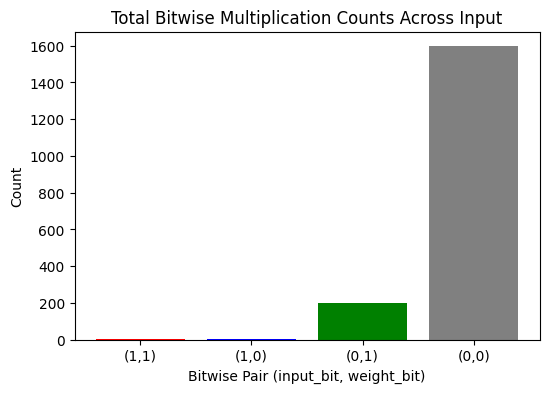

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict

global_counts = defaultdict(int)
H, W = reuse_map.shape

for i in range(H):
    for j in range(W):
        for pair, count in bitpair_map[i][j].items():
            global_counts[pair] += count

pairs = list(global_counts.keys())
counts = [global_counts[p] for p in pairs]

plt.figure(figsize=(6,4))
plt.bar(pairs, counts, color=['red','blue','green','gray'])
plt.title("Total Bitwise Multiplication Counts Across Input")
plt.ylabel("Count")
plt.xlabel("Bitwise Pair (input_bit, weight_bit)")
plt.show()


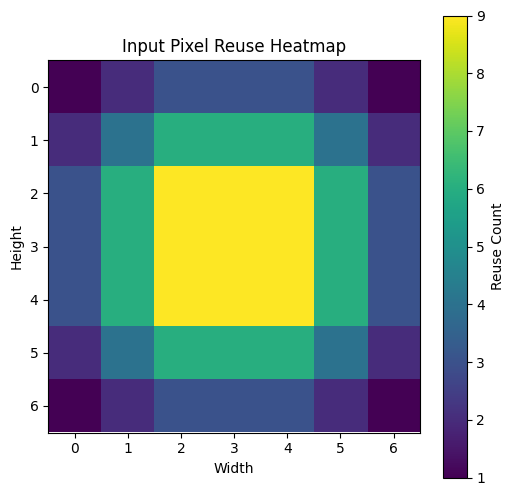

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(reuse_map.numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Reuse Count')
plt.title('Input Pixel Reuse Heatmap')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()
